In [1]:
# Install the necessary libraries
!pip3 install emoji
!pip3 install contractions
!pip3 install keras_tuner
!pip3 install transformers
!pip3 install tweepy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 30.3 MB/s 
  Created wheel for emoji: filename=emoji-2.0.0-py3-none-any.whl size=193022 sha256=78ceaf6e7d2aeca3a2eab84dfbad5c4110bde47a51e97315c34aabf037a1a98e
  Stored in directory: /root/.cache/pip/wheels/ec/29/4d/3cfe7452ac7d8d83b1930f8a6205c3c9649b24e80f9029fc38
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 35.7 MB/s 
     |████████████████████████████████| 287 kB 48.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 7.0 MB/s 
     |████████████████████████████████| 1.6 MB 42.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████

In [2]:
# Import the necessary libraries
import re
import os
import pandas as pd
import xml.etree.ElementTree as ET
from tqdm import tqdm
tqdm.pandas()

import emoji
import string
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GroupShuffleSplit
from sklearn.utils import shuffle

from scipy.stats import uniform
import pickle

from keras_preprocessing.sequence import pad_sequences

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, GRU, Bidirectional, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch, Objective
from keras.utils.vis_utils import plot_model

import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, EarlyStoppingCallback, TrainingArguments, Trainer
import shutil

from keras.models import load_model
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

# Data Extraction - Italian

In [3]:
# Download and unzip the dataset
!wget https://raw.githubusercontent.com/msang/hate-speech-corpus/master/IHSC_ids.tsv

--2022-09-15 20:16:51--  https://raw.githubusercontent.com/msang/hate-speech-corpus/master/IHSC_ids.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253841 (248K) [text/plain]
Saving to: ‘IHSC_ids.tsv’

IHSC_ids.tsv        100%[===================>] 247.89K  --.-KB/s    in 0.003s  

2022-09-15 20:16:51 (74.5 MB/s) - ‘IHSC_ids.tsv’ saved [253841/253841]



In [4]:
# Load the dataset into a dataframe
df = pd.read_csv('/content/IHSC_ids.tsv', sep='\t', header=0)

In [5]:
df = df.replace('yes', 1)
df = df.replace('no', 0)
df = df.replace('strong', 1)
df = df.replace('weak', 0.5)

In [6]:
# Preview the dataset
print(f"Number of offensive tweets: {df[df['hs'] == 1].shape[0]}")
print(f"Number of non-offensive tweets: {df[df['hs'] == 0].shape[0]}")
df.head()

Number of offensive tweets: 1291
Number of non-offensive tweets: 5637


,tweet_id,hs,aggressiveness,offensiveness,irony,stereotype
0,803574238733107200,0,0.0,0.0,1,0
1,810090293328539649,0,0.0,0.0,0,0
2,801894698952564736,0,0.0,0.0,0,0
3,831441652262772741,0,0.0,0.0,0,0
4,790512245373632512,0,0.0,0.0,0,1


In [7]:
def split(list_a, chunk_size):

  for i in range(0, len(list_a), chunk_size):
    yield list_a[i:i + chunk_size]

ids = df['tweet_id'].tolist()
ids = split(ids, 100)

In [8]:
import tweepy
  
# REMOVE WHEN SUBMITTING PROJECT
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAGIPfgEAAAAAm7LfxM55JvVjj0xzMpENlo%2BiUmc%3DaNWCKQaojcFb9tmTTnk6lcL8pSKtwOvcroXuFCTg0wrNloWxKn'

auth = tweepy.Client(bearer_token, wait_on_rate_limit=True)
api = tweepy.API(auth)  

text = []
errors = []
# the ID of the status
for id in ids:

  tweet = auth.get_tweets(id)
  
  for t in tweet.data:
    text.append(t['text'])
  for e in tweet.errors:
    df = df[df.tweet_id != int(e['resource_id'])]

df['tweet_text'] = text

In [9]:
df = df.reset_index()
df.head()

,index,tweet_id,hs,aggressiveness,offensiveness,irony,stereotype,tweet_text
0,0,803574238733107200,0,0.0,0.0,1,0,@Dandy_Dv @M_P_8 @JimmyGhione @virginiaraggi m...
1,1,810090293328539649,0,0.0,0.0,0,0,"Studentessa cinese morta a Roma, fermati due g..."
2,2,801894698952564736,0,0.0,0.0,0,0,"Roma, “tangenti per appalti\nsui campi rom”: c..."
3,3,831441652262772741,0,0.0,0.0,0,0,"""I rom sono la sola comunità in Italia vittima..."
4,5,846470648746708998,0,0.0,0.0,1,0,La #Raggi dopo un anno comincia a far qualcosa...


# Data Cleaning

In [10]:
# Utilised functions
# Normalize sequences of at least 3 repeated characters with a maximum of two letters
def replace_more_than_three(s):
    pattern = re.compile(r"(.)\1{2,}", re.DOTALL) 
    return pattern.sub(r"\1\1", s)
    
def clean_text(sentence):
    
    # Remove reference to twitter @users, links and #hashtags
    sentence = re.sub("(@[A-Za-z0-9_]+)"," ",sentence)
    sentence = re.sub(r'http\S+', '', sentence)
    sentence = re.sub("#[A-Za-z0-9_]+","", sentence)

    # Normalize sequences of at least 3 repeated characters with a maximum of two letters (ex: hiiiiii -> hii)
    sentence = replace_more_than_three(sentence)

    # Remove numbers
    sentence = re.sub(r'\d+', '', sentence)

    # Remove punctuation
    sentence = re.sub(r'[^\w\s]', ' ', sentence)

    # Transform emojis into their aliases
    sentence = emoji.demojize(sentence)
    sentence = re.sub(r':', ' ', sentence)

    # Remove extra white spaces
    sentence = ' '.join(sentence.split())

    # Remove any left or right spacing
    sentence.strip()

    return sentence

In [11]:
# Clean the raw texts
df['clean'] = df['tweet_text'].progress_apply(lambda txt: clean_text(txt))

# Rearrange the columns
df = df[['tweet_id', 'tweet_text', 'clean', 'hs', 'aggressiveness', 'offensiveness', 'irony', 'stereotype']]

100%|██████████| 5141/5141 [00:00<00:00, 8414.31it/s]


In [12]:
# Preview the dataset
df.head()

,tweet_id,tweet_text,clean,hs,aggressiveness,offensiveness,irony,stereotype
0,803574238733107200,@Dandy_Dv @M_P_8 @JimmyGhione @virginiaraggi m...,ma infatti il campo rom è sorto a settembre e ...,0,0.0,0.0,1,0
1,810090293328539649,"Studentessa cinese morta a Roma, fermati due g...",Studentessa cinese morta a Roma fermati due gi...,0,0.0,0.0,0,0
2,801894698952564736,"Roma, “tangenti per appalti\nsui campi rom”: c...",Roma tangenti per appalti sui campi rom chiest...,0,0.0,0.0,0,0
3,831441652262772741,"""I rom sono la sola comunità in Italia vittima...",I rom sono la sola comunità in Italia vittima ...,0,0.0,0.0,0,0
4,846470648746708998,La #Raggi dopo un anno comincia a far qualcosa...,La dopo un anno comincia a far qualcosa E comi...,0,0.0,0.0,1,0


In [13]:
# Divide the dataset into training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(df['clean'], df[['hs', 'aggressiveness', 'offensiveness', 'irony', 'stereotype']], test_size=0.2, shuffle=True, random_state=8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, shuffle=True, random_state=8) # 0.125 x 0.8 = 0.1
print(f'Number of tweets in training set: {X_train.shape[0]}')
print(f'Number of tweets in validation set: {X_val.shape[0]}')
print(f'Number of tweets in test set: {X_test.shape[0]}')

Number of tweets in training set: 3598
Number of tweets in validation set: 514
Number of tweets in test set: 1029


In [14]:
# Test sets split by labels other than hate speech
full_test = X_test.to_frame().join(y_test)
irony = full_test.loc[full_test['irony'] == 1]
aggressiveness = full_test.loc[full_test['aggressiveness'] >= 0.5]
offensiveness = full_test.loc[full_test['offensiveness'] >= 0.5]
stereotype = full_test.loc[full_test['stereotype'] == 1]
X_test_irony = irony['clean']
y_test_irony = irony['hs']
X_test_aggressiveness = aggressiveness['clean']
y_test_aggressiveness = aggressiveness['hs']
X_test_stereotype = stereotype['clean']
y_test_stereotype = stereotype['hs']
X_test_offensiveness = offensiveness['clean']
y_test_offensiveness = offensiveness['hs']

In [15]:
X_test_irony[1833]

'ma poi inviteranno al torneo di golf anche i terremotati e agli immigrati sarà dato un bonus x fornitur dell attrezzatura'

## Dataset inspection


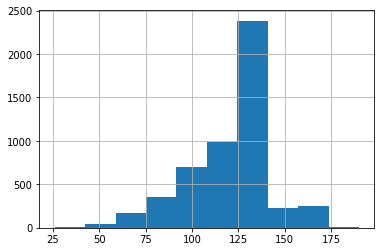

In [16]:
# Tweets lenght
df['tweet_text'].str.len().hist()

In [17]:
# Balance of the train dataset.
print(f"There are {np.sum(df['hs'])} positive samples and {len(df['hs']) - np.sum(df['hs'])} negative samples over {len(df['hs'])} samples of the training set.")

There are 809 positive samples and 4332 negative samples over 5141 samples of the training set.


# Modelling

In [18]:
def plot_cm(labels, pred, normalize = 'true'):
    cm = confusion_matrix(labels, pred, normalize = normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not-hate', 'hate'])
    disp.plot()

## Model (Transformer)

In [19]:
# Utilised functions
class Dataset(torch.utils.data.Dataset):    
    def __init__(self, inputs, labels):          
        self.inputs = inputs['input_ids']
        self.attentions = inputs['attention_mask']      
        self.labels = labels

    def __len__(self):
        return len(self.inputs)
     
    def __getitem__(self, idx):
        input = self.inputs[idx]
        attention = self.attentions[idx]

        if self.labels is None:
            sample = {'input_ids': input, 'attention_mask': attention}
        
        else:
            label = self.labels[idx]
            sample = {'input_ids': input, 'attention_mask': attention, 'labels': label}
        
        return sample

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    f1 = f1_score(labels, pred, average='macro')
    return {'f1': f1}

In [20]:
# Check if the GPU is available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [21]:
# Not used as equal weights had best performance
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

### bert-base-italian-cased (Italian Transformer)

In [ ]:
# Import the transformer model
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-italian-cased")

In [ ]:
# Encode the texts using a pretrained tokenizer
train_features = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
val_features = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt')
test_features = tokenizer(list(X_test), truncation=True, padding=True, return_tensors='pt')

# Change data type of labels to int64
train_labels = y_train['hs'].astype('int64')
val_labels = y_val['hs'].astype('int64')
test_labels = y_test['hs'].astype('int64')

# Create the training, validation and test datasets
train_dataset = Dataset(train_features, list(train_labels))
val_dataset = Dataset(val_features, list(val_labels))
test_dataset = Dataset(test_features, None)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("dbmdz/bert-base-italian-cased", num_labels=2, ignore_mismatched_sizes=True).to(device)

Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

In [ ]:
# Define the trainer
args = TrainingArguments(
    output_dir='output',
    evaluation_strategy ='steps',
    logging_steps=25,
    eval_steps=25,
    save_total_limit=1,
    learning_rate=1e-5,
    per_device_train_batch_size=128,
    num_train_epochs=7,
    metric_for_best_model='f1',
    load_best_model_at_end=True)

best_transformer_model = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,   
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)])
  
# Train the pre-trained model
best_transformer_model.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3590
  Num Epochs = 7
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 203


Step,Training Loss,Validation Loss,F1
25,0.517200,0.416765,0.458861
50,0.423500,0.386424,0.458861
75,0.371300,0.388912,0.458861
100,0.379700,0.373089,0.458861
125,0.342800,0.364543,0.458861
150,0.332400,0.360970,0.543097
175,0.310000,0.360273,0.573718
200,0.308600,0.359829,0.570152


***** Running Evaluation *****
  Num examples = 513
  Batch size = 8
***** Running Evaluation *****
  Num examples = 513
  Batch size = 8
***** Running Evaluation *****
  Num examples = 513
  Batch size = 8
***** Running Evaluation *****
  Num examples = 513
  Batch size = 8
***** Running Evaluation *****
  Num examples = 513
  Batch size = 8
***** Running Evaluation *****
  Num examples = 513
  Batch size = 8
***** Running Evaluation *****
  Num examples = 513
  Batch size = 8
***** Running Evaluation *****
  Num examples = 513
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




In [ ]:
# Save the trained transfomer as a zip file
os.makedirs('/content/best_transformer_model')
model.save_pretrained('/content/best_transformer_model')
shutil.make_archive('best_transformer_model', 'zip', '/content/best_transformer_model')

Configuration saved in /content/best_transformer_model/config.json
Model weights saved in /content/best_transformer_model/pytorch_model.bin


***** Running Prediction *****
  Num examples = 1026
  Batch size = 8


              precision    recall  f1-score   support

           0       0.87      0.98      0.92       870
           1       0.67      0.21      0.31       156

    accuracy                           0.86      1026
   macro avg       0.77      0.59      0.62      1026
weighted avg       0.84      0.86      0.83      1026



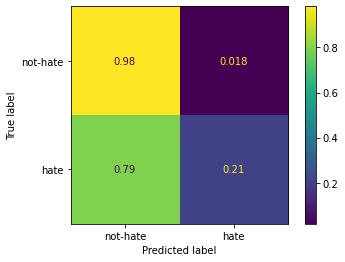

In [ ]:
# Evaluate the best transformer model on the test set
transformer_pred = best_transformer_model.predict(test_dataset)
true, pred = y_test['hs'], [np.argmax(s) for s in transformer_pred[0]]
print(classification_report(true, pred))
plot_cm(true, pred)

### twitter-xlm-roberta-base (Multilingual Transformer)

In [ ]:
# Import the transformer model
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base")

Downloading:   0%|          | 0.00/652 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
# Encode the texts using a pretrained tokenizer
train_features = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
val_features = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt')
test_features = tokenizer(list(X_test), truncation=True, padding=True, return_tensors='pt')

# Change data type of labels to int64
train_labels = y_train['hs'].astype('int64')
val_labels = y_val['hs'].astype('int64')
test_labels = y_test['hs'].astype('int64')

# Create the training, validation and test datasets
train_dataset = Dataset(train_features, list(train_labels))
val_dataset = Dataset(val_features, list(val_labels))
test_dataset = Dataset(test_features, None)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-xlm-roberta-base")

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['classifier.out

In [ ]:
# Define the trainer
args = TrainingArguments(
    output_dir='output',
    evaluation_strategy ='steps',
    logging_steps=25,
    eval_steps=25,
    save_total_limit=1,
    learning_rate=1e-5,
    per_device_train_batch_size=128,
    num_train_epochs=7,
    metric_for_best_model='f1',
    load_best_model_at_end=True)

best_multilingual_transformer_model = CustomTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,   
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)])
  
# Train the pre-trained model
best_multilingual_transformer_model.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3598
  Num Epochs = 7
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 203


Step,Training Loss,Validation Loss,F1
25,0.612200,0.531244,0.460168
50,0.534800,0.465344,0.460168
75,0.491800,0.407391,0.681872
100,0.432000,0.396819,0.717582
125,0.385400,0.384059,0.737351
150,0.395300,0.433743,0.681338
175,0.367500,0.389566,0.731077
200,0.350900,0.390294,0.724729


***** Running Evaluation *****
  Num examples = 515
  Batch size = 8
***** Running Evaluation *****
  Num examples = 515
  Batch size = 8
***** Running Evaluation *****
  Num examples = 515
  Batch size = 8
***** Running Evaluation *****
  Num examples = 515
  Batch size = 8
***** Running Evaluation *****
  Num examples = 515
  Batch size = 8
***** Running Evaluation *****
  Num examples = 515
  Batch size = 8
***** Running Evaluation *****
  Num examples = 515
  Batch size = 8
***** Running Evaluation *****
  Num examples = 515
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=203, training_loss=0.4455920545925648, metrics={'train_runtime': 201.199, 'train_samples_per_second': 125.18, 'train_steps_per_second': 1.009, 'total_flos': 582426126588600.0, 'train_loss': 0.4455920545925648, 'epoch': 7.0})

In [ ]:
# Save the trained transfomer as a zip file
os.makedirs('/content/best_multilingual_transformer_model')
model.save_pretrained('/content/best_multilingual_transformer_model')
shutil.make_archive('best_multilingual_transformer_model', 'zip', '/content/best_multilingual_transformer_model')

Configuration saved in /content/best_multilingual_transformer_model/config.json
Model weights saved in /content/best_multilingual_transformer_model/pytorch_model.bin


'/content/best_multilingual_transformer_model.zip'

***** Running Prediction *****
  Num examples = 1029
  Batch size = 8


              precision    recall  f1-score   support

           0       0.94      0.83      0.88       880
           1       0.40      0.66      0.50       149

    accuracy                           0.81      1029
   macro avg       0.67      0.75      0.69      1029
weighted avg       0.86      0.81      0.83      1029



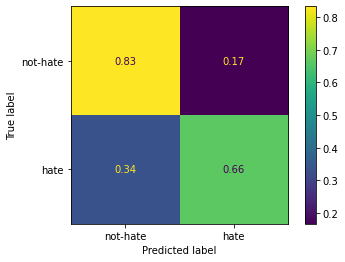

In [ ]:
# Evaluate the best multilingual transformer model on the test set
transformer_pred = best_multilingual_transformer_model.predict(test_dataset)
true, pred = y_test['hs'], [np.argmax(s) for s in transformer_pred[0]]
print(classification_report(true, pred))
plot_cm(true, pred)

### bertweet-base-sentiment-analysis (Transformer using Translated tweets)


In [22]:
# Download the translated tweets (translated with Google Translate)
!gdown --id 1CBkYCU7o5DNcBqXfiWjWU6GpcGw_J9BW
translated_df = pd.DataFrame()
translated_df['translated'] = pd.read_csv('translated_tweets.csv')['clean']

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1CBkYCU7o5DNcBqXfiWjWU6GpcGw_J9BW
To: /content/translated_tweets.csv
100% 511k/511k [00:00<00:00, 108MB/s]


In [23]:
# Map the english translated tweet into the original italian ones 
X_train_translated = pd.merge(X_train, translated_df, left_index=True, right_index=True)['translated']
X_val_translated = pd.merge(X_val, translated_df, left_index=True, right_index=True)['translated']
X_test_translated = pd.merge(X_test, translated_df, left_index=True, right_index=True)['translated']

In [24]:
# Import the transformer model
tokenizer = AutoTokenizer.from_pretrained('finiteautomata/bertweet-base-sentiment-analysis')

Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/890 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [25]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 5.0, 1.0]).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [26]:
# Encode the texts using a pretrained tokenizer
train_features = tokenizer(list(X_train_translated), truncation=True, padding=True, return_tensors='pt')
val_features = tokenizer(list(X_val_translated), truncation=True, padding=True, return_tensors='pt')
test_features = tokenizer(list(X_test_translated), truncation=True, padding=True, return_tensors='pt')

# Change data type of labels to int64
train_labels = y_train['hs'].astype('int64')
val_labels = y_val['hs'].astype('int64')
test_labels = y_test['hs'].astype('int64')

# Create the training, validation and test datasets
train_dataset = Dataset(train_features, list(train_labels))
val_dataset = Dataset(val_features, list(val_labels))
test_dataset = Dataset(test_features, None)

In [27]:
model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")

Downloading:   0%|          | 0.00/540M [00:00<?, ?B/s]

In [28]:
# Define the trainer
args = TrainingArguments(
    output_dir='output',
    evaluation_strategy ='steps',
    logging_steps=25,
    eval_steps=25,
    save_total_limit=1,
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    num_train_epochs=7,
    metric_for_best_model='f1',
    load_best_model_at_end=True)

best_translated_transformer_model = CustomTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,   
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)])
  
# Train the pre-trained model
best_translated_transformer_model.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3598
  Num Epochs = 7
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 203


Step,Training Loss,Validation Loss,F1
25,0.876400,0.667371,0.466251
50,0.690700,0.693008,0.385314
75,0.673900,0.687830,0.451327
100,0.625600,0.584740,0.609843
125,0.591200,0.581060,0.617394
150,0.550300,0.632915,0.582503
175,0.520700,0.582649,0.610906
200,0.500200,0.614138,0.613087


***** Running Evaluation *****
  Num examples = 514
  Batch size = 8
***** Running Evaluation *****
  Num examples = 514
  Batch size = 8
***** Running Evaluation *****
  Num examples = 514
  Batch size = 8
***** Running Evaluation *****
  Num examples = 514
  Batch size = 8
***** Running Evaluation *****
  Num examples = 514
  Batch size = 8
***** Running Evaluation *****
  Num examples = 514
  Batch size = 8
***** Running Evaluation *****
  Num examples = 514
  Batch size = 8
***** Running Evaluation *****
  Num examples = 514
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=203, training_loss=0.6252049642243409, metrics={'train_runtime': 167.6563, 'train_samples_per_second': 150.224, 'train_steps_per_second': 1.211, 'total_flos': 491830922808792.0, 'train_loss': 0.6252049642243409, 'epoch': 7.0})

In [29]:
# Save the transfomer weights folder as a zip file
os.makedirs('/content/best_translated_transformer_model')
model.save_pretrained('/content/best_translated_transformer_model')
shutil.make_archive('best_translated_transformer_model', 'zip', '/content/output')

Configuration saved in /content/best_translated_transformer_model/config.json
Model weights saved in /content/best_translated_transformer_model/pytorch_model.bin


'/content/best_translated_transformer_model.zip'

***** Running Prediction *****
  Num examples = 1029
  Batch size = 8


              precision    recall  f1-score   support

           0       0.90      0.77      0.83       873
           1       0.28      0.50      0.36       156

    accuracy                           0.73      1029
   macro avg       0.59      0.63      0.59      1029
weighted avg       0.80      0.73      0.76      1029



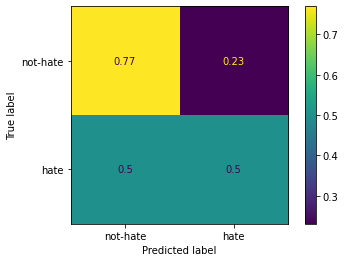

In [30]:
# Evaluate the best multilingual transformer model on the test set
transformer_pred = best_translated_transformer_model.predict(test_dataset)
true, pred = y_test['hs'], [np.argmax(s) for s in transformer_pred[0]]
print(classification_report(true, pred))
plot_cm(true, pred)

### bert_uncased_L-12_H-768_A-12_italian_alb3rt0 (Italian Trasformer on Tweet)

In [ ]:
# Import the transformer model
tokenizer = AutoTokenizer.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

In [ ]:
# Encode the texts using a pretrained tokenizer
train_features = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
val_features = tokenizer(list(X_val), truncation=True, padding=True, return_tensors='pt')
test_features = tokenizer(list(X_test), truncation=True, padding=True, return_tensors='pt')

# Change data type of labels to int64
train_labels = y_train['hs'].astype('int64')
val_labels = y_val['hs'].astype('int64')
test_labels = y_test['hs'].astype('int64')

# Create the training, validation and test datasets
train_dataset = Dataset(train_features, list(train_labels))
val_dataset = Dataset(val_features, list(val_labels))
test_dataset = Dataset(test_features, None)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0").to(device)
#model = AutoModel.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")

Downloading:   0%|          | 0.00/740M [00:00<?, ?B/s]

Some weights of the model checkpoint at m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were

In [ ]:
# Define the trainer
args = TrainingArguments(
    output_dir='output',
    evaluation_strategy ='steps',
    logging_steps=25,
    eval_steps=25,
    save_total_limit=1,
    learning_rate=1e-5,
    per_device_train_batch_size=128,
    num_train_epochs=7,
    metric_for_best_model='f1',
    load_best_model_at_end=True)

best_transformer_model_it_tweet = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,   
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)])
  
# Train the pre-trained model
best_transformer_model_it_tweet.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3598
  Num Epochs = 7
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 203


Step,Training Loss,Validation Loss,F1
25,0.395900,0.291161,0.604651
50,0.296300,0.270911,0.744415
75,0.280600,0.322522,0.723595
100,0.232500,0.254615,0.770509
125,0.226900,0.261753,0.756629
150,0.194200,0.261041,0.751563
175,0.191100,0.268202,0.757522
200,0.180100,0.266453,0.754253


***** Running Evaluation *****
  Num examples = 514
  Batch size = 8
***** Running Evaluation *****
  Num examples = 514
  Batch size = 8
***** Running Evaluation *****
  Num examples = 514
  Batch size = 8
***** Running Evaluation *****
  Num examples = 514
  Batch size = 8
***** Running Evaluation *****
  Num examples = 514
  Batch size = 8
***** Running Evaluation *****
  Num examples = 514
  Batch size = 8
***** Running Evaluation *****
  Num examples = 514
  Batch size = 8
***** Running Evaluation *****
  Num examples = 514
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=203, training_loss=0.24834395864326966, metrics={'train_runtime': 152.486, 'train_samples_per_second': 165.169, 'train_steps_per_second': 1.331, 'total_flos': 414169690018560.0, 'train_loss': 0.24834395864326966, 'epoch': 7.0})

In [ ]:
# Save the trained transfomer as a zip file
os.makedirs('/content/best_transformer_model')
model.save_pretrained('/content/best_transformer_model')
shutil.make_archive('best_transformer_model', 'zip', '/content/best_transformer_model')

Configuration saved in /content/best_transformer_model/config.json
Model weights saved in /content/best_transformer_model/pytorch_model.bin


'/content/best_transformer_model.zip'

***** Running Prediction *****
  Num examples = 1029
  Batch size = 8


              precision    recall  f1-score   support

           0       0.92      0.93      0.93       873
           1       0.61      0.57      0.59       156

    accuracy                           0.88      1029
   macro avg       0.76      0.75      0.76      1029
weighted avg       0.88      0.88      0.88      1029



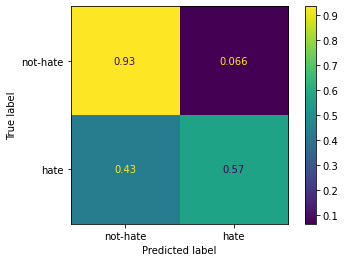

In [ ]:
# Evaluate the best transformer model on the test set
transformer_pred = best_transformer_model_it_tweet.predict(test_dataset)
true, pred = y_test['hs'], [np.argmax(s) for s in transformer_pred[0]]
print(classification_report(true, pred))
plot_cm(true, pred)

In [ ]:
# Encode the texts using a pretrained tokenizer
irony_features = tokenizer(list(X_test_irony), truncation=True, padding=True, return_tensors='pt')
aggressiveness_features = tokenizer(list(X_test_aggressiveness), truncation=True, padding=True, return_tensors='pt')
offensiveness_features = tokenizer(list(X_test_offensiveness), truncation=True, padding=True, return_tensors='pt')
stereotype_features = tokenizer(list(X_test_stereotype), truncation=True, padding=True, return_tensors='pt')

# Change data type of labels to int64
irony_labels = y_test_irony.astype('int64')
agressiveness_labels = y_test_aggressiveness.astype('int64')
offensiveness_labels = y_test_offensiveness.astype('int64')
stereotype_labels = y_test_stereotype.astype('int64')

irony_dataset = Dataset(irony_features, None)
aggressiveness_dataset = Dataset(aggressiveness_features, None)
offensiveness_dataset = Dataset(offensiveness_features, None)
stereotype_dataset = Dataset(stereotype_features, None)

***** Running Prediction *****
  Num examples = 124
  Batch size = 8


              precision    recall  f1-score   support

           0       0.93      0.84      0.88       107
           1       0.37      0.59      0.45        17

    accuracy                           0.81       124
   macro avg       0.65      0.71      0.67       124
weighted avg       0.85      0.81      0.82       124



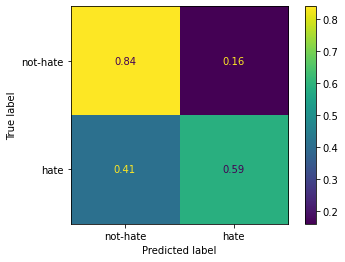

In [ ]:
# Irony
transformer_pred = best_transformer_model_it_tweet.predict(irony_dataset)
true, pred = y_test_irony, [np.argmax(s) for s in transformer_pred[0]]
print(classification_report(true, pred))
plot_cm(true, pred)

***** Running Prediction *****
  Num examples = 186
  Batch size = 8


              precision    recall  f1-score   support

           0       0.68      0.77      0.72        88
           1       0.77      0.67      0.72        98

    accuracy                           0.72       186
   macro avg       0.72      0.72      0.72       186
weighted avg       0.73      0.72      0.72       186



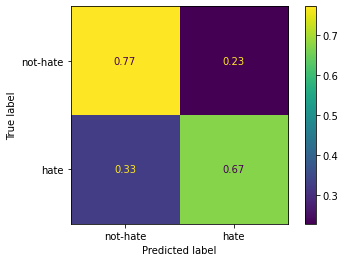

In [ ]:
# Agressiveness
transformer_pred = best_transformer_model_it_tweet.predict(aggressiveness_dataset)
true, pred = y_test_aggressiveness, [np.argmax(s) for s in transformer_pred[0]]
print(classification_report(true, pred))
plot_cm(true, pred)

***** Running Prediction *****
  Num examples = 178
  Batch size = 8


              precision    recall  f1-score   support

           0       0.67      0.81      0.73        81
           1       0.81      0.66      0.73        97

    accuracy                           0.73       178
   macro avg       0.74      0.74      0.73       178
weighted avg       0.74      0.73      0.73       178



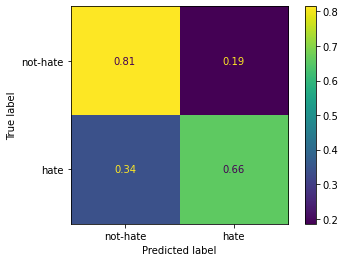

In [ ]:
# Offensiveness
transformer_pred = best_transformer_model_it_tweet.predict(offensiveness_dataset)
true, pred = y_test_offensiveness, [np.argmax(s) for s in transformer_pred[0]]
print(classification_report(true, pred))
plot_cm(true, pred)

***** Running Prediction *****
  Num examples = 281
  Batch size = 8


              precision    recall  f1-score   support

           0       0.80      0.86      0.83       176
           1       0.74      0.65      0.69       105

    accuracy                           0.78       281
   macro avg       0.77      0.76      0.76       281
weighted avg       0.78      0.78      0.78       281



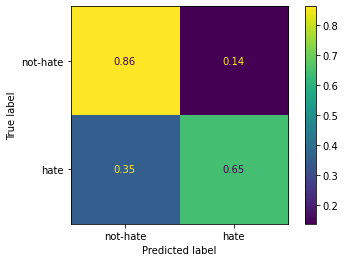

In [ ]:
# Stereotype
transformer_pred = best_transformer_model_it_tweet.predict(stereotype_dataset)
true, pred = y_test_stereotype, [np.argmax(s) for s in transformer_pred[0]]
print(classification_report(true, pred))
plot_cm(true, pred)